# Seismic Attributes

Seismic attributes can be defined as all available information deduced from the seismic data,
either by direct measurements or by logical or
experience-based reasoning, such as seismic
velocity, frequency content, dip and continuity
of events, seismic wavelet specifications,
amplitude and phase relationships, attenuation
effects, etc. Instantaneous attributes do not represent the variations within a specified time window, but characterize instantaneous changes in
the seismic traces.

There are several different types of seismic
attributes widely used in the seismic processing
industry today. A specific attribute type is
known as a complex trace attribute, introduced
by Taner et al. (1979), which provides additional
information about the phase, amplitude and frequency characteristics of the recorded signal.
Complex trace attributes are commonly used
as secondary tools for direct hydrocarbon indicator (DHI) analysis, especially in the case of
high-amplitude bright reflections and frequency
anomalies. In order to obtain suitable and reliable information, true amplitude processing of
the data must be required, which preserves relative amplitude information and frequency content of the reflected signal.

## Seismic Data

General

Country: The Netherlands

Location: Offshore, North Sea

Blocks: F3

Coordinates: N 54° 52’ 0.86” / E 4° 48’ 47.07”

Acquisition: 1987


Data summary:
OpendTect project with 3D Seismic Data, Acoustic Impedance, Wells, Horizons

In [133]:
import numpy as np 
data = np.load("F3_seismic.npy")
data.shape

(10, 250, 463)

Here seismic data has a shape of (10, 250, 463), which represents a 3D seismic volume where the first dimension (10) corresponds to the number of inlines (slices through the volume), the second (250) to the number of traces per inline (crossline direction), and the third (463) to the number of time or depth samples per trace.For example, When we select data[6], we extract the 7th inline, which gives us a 2D slice of shape (250, 463), where each row is a seismic trace and each column represents a time sample. To visualize this slice in a standard seismic view with time on the vertical axis and traces on the horizontal axis, we transpose the (data[6].T) to get a shape of (463, 250) before displaying it using imshow. This allows us to observe how the seismic signal varies with time across traces for a specific inline.

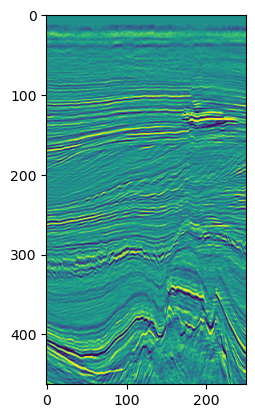

In [134]:
import matplotlib.pyplot as plt 
plt.imshow(data[6].T)

# Complex Trace Attributes
## Envelope ( aka reflection strength, instantaneous amplitude)

Complex trace attributes are calculated by using the Hilbert transform. Although the total energy in a dynamic system consists of the summation of kinetic and potential energy, seismic receivers (geophones or
hydrophones) measure only the kinetic energy component. The analytical signal u(t) expressed by Eqquation represents the total
energy in wave propagation. Considering the seismic data as an analytic signal with real and imaginary components, kinetic and potential
energy are proportional to the real and the imaginary component, respectively. In complex trace attribute calculations, the recorded seismic signal represents the kinetic energy, whereas the
imaginary component corresponds to potential energy.

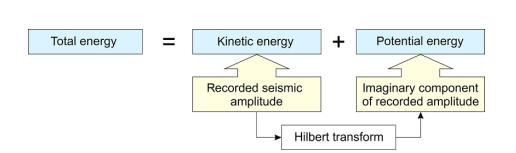
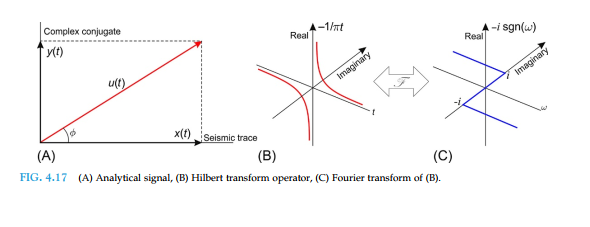

Considering the recorded trace as the real
component of the analytical signal, its imaginary
component is calculated by the Hilbert transform, and the recorded trace and its Hilbert
transform constitute a Hilbert transform pair,
which can be used to achieve some additional
parameters in terms of instantaneous attributes.

$$
g(t) = \sqrt{x(t)^2 + y(t)^2}
$$

$$
\phi(t) = \atan\left(\frac{y(t)}{x(t)}\right)
$$

$$
\omega(t) = \frac{\partial \phi(t)}{\partial t}
$$

**The time-dependent analytical function** \( u(t) \) **is a complex function and can be defined as:**

$$
u(t) = x(t) + i y(t)
$$

where \( x(t) \) and \( y(t) \) are real and imaginary components, respectively, and are known as the **Hilbert transform pair**.



where x(t) is the real component of the analytical
signal (the recorded trace), y(t) is the imaginary
component (Hilbert transform of x(t)), g(t) is the
instantaneous amplitude or envelope, ϕ(t) is the
instantaneous phase, and ω(t) is the instantaneous frequency. An additional parameter
called apparent polarity can be obtained from
the envelope trace, which equals the polarity
at the trace envelope peaks, and is generally
weighted by the envelope peak value.

In [135]:
from scipy.signal import hilbert
def instantaneous_amplitude(traces):
    """
    Compute instantaneous amplitude, also known as the envelope or
    reflection strength.

    The attribute is computed over the last dimension. That is, time should
    be in the last dimension, so a 100 inline, 100 crossline seismic volume
    with 250 time slices would have shape (100, 100, 250).

    Args:
        traces (ndarray): The data array to use for calculating energy.
    Returns:
        ndarray: An array the same dimensions as the input array.
    """
    return np.abs(hilbert(traces))


envelope = instantaneous_amplitude
reflection_strength = instantaneous_amplitude

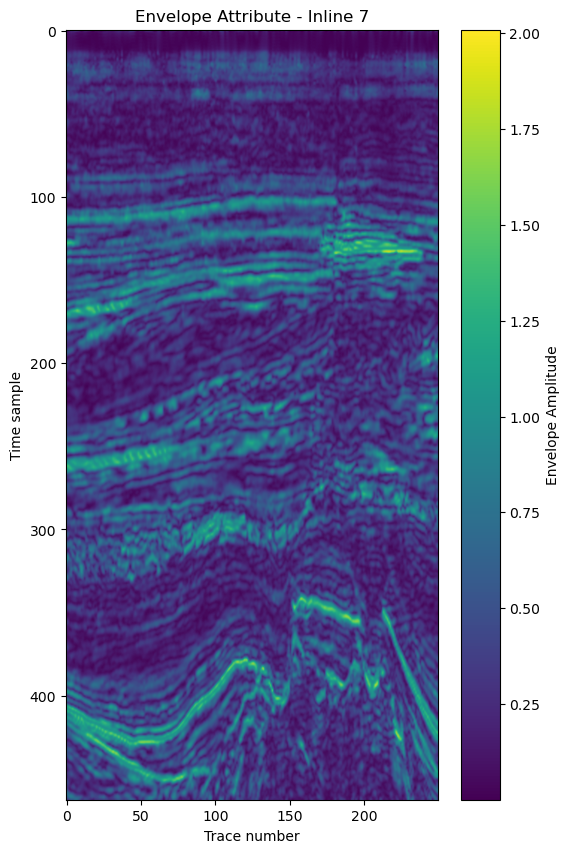

In [136]:
env = envelope(data)
plt.figure(figsize=(6,10))
plt.imshow(env[6].T, aspect='auto', interpolation='bicubic')
plt.title("Envelope Attribute - Inline 7")
plt.xlabel("Trace number")
plt.ylabel("Time sample")
plt.colorbar(label="Envelope Amplitude")
plt.show()

## Instantaneous Phase

In [160]:
def instantaneous_phase(traces):
    return np.angle(hilbert(traces))

Lets extracts the instantaneous phase and plots a single 2D inline section using a circular color map 

(A circular colormap is a special type of color scale designed to represent values that naturally "wrap around," such as phase data, angles, or directions, where:

1. 0° and 360° are equivalent

2. π and -π represent the same phase angle

3. The data is periodic) 

that highlights phase continuity and discontinuities. It's particularly useful for identifying geological features like faults, unconformities, or thin beds that may not be clear in amplitude alone.

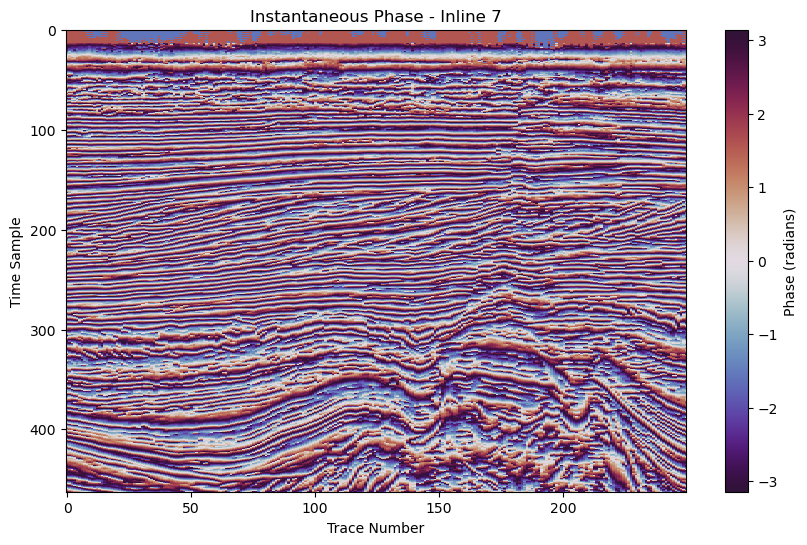

In [161]:
# Calculate instantaneous phase
phase = instantaneous_phase(data)

# Plot the 9th inline's phase
plt.figure(figsize=(10, 6))
plt.imshow(phase[6].T, cmap='twilight_shifted', interpolation='none', aspect='auto')
plt.title("Instantaneous Phase - Inline 7")
plt.xlabel("Trace Number")
plt.ylabel("Time Sample")
plt.colorbar(label="Phase (radians)")
plt.show()

## Instantaneous Frequency 

Instantaneous frequency is a valuable seismic attribute that reflects how rapidly the phase of a seismic signal changes with time. Mathematically, it is defined as the derivative of the instantaneous phase:
$$
\omega(t) = \frac{\partial \phi(t)}{\partial t}
$$
ω(t) is the instantaneous frequency in radians per second (or Hz if scaled).

Instantaneous frequency helps to:
1. Highlight thin beds and stratigraphic features,
2. Detect lithological changes,
3. Identify hydrocarbon indicators, especially tuning effects,
4. Enhance resolution in high-frequency zones.

In [139]:
def quadrature(traces):
    h = hilbert(traces)
    return np.abs(h) * np.sin(np.log(h).imag)

### Claerbout’s Method (1985)

In [140]:
def inst_freq_claerbout(traces, dt):
    """
    Instantaneous frequency using Claerbout's method (1985).
    
    """
    h = hilbert(traces, axis=0)
    numerator = h[1:] - h[:-1]
    denominator = h[1:] + h[:-1]
    term = numerator / denominator
    inst_freq = (1 / (np.pi * dt)) * np.imag(term)

    # Pad to match original shape
    pad = inst_freq[..., -1:]  # shape (x, y, 1)
    inst_freq = np.concatenate((inst_freq, pad), axis=-1)
    return inst_freq



### Scheuer & Oldenburg Method (1988)

In [162]:
def inst_freq_scheuer_oldenburg(traces, dt):
    """
    Instantaneous frequency using Scheuer & Oldenburg method (1988).
    """
    x = traces
    y = np.imag(hilbert(traces, axis=0))  # Quadrature component
    numerator = (x[:-1] * y[1:]) - (x[1:] * y[:-1])
    denominator = (x[:-1] * x[1:]) + (y[1:] * y[:-1])
    term = numerator / denominator
    inst_freq = (1 / (2 * np.pi * dt)) * np.arctan(term)

    # Pad to match original shape
    pad = inst_freq[..., -1:]  # shape (x, y, 1)
    inst_freq = np.concatenate((inst_freq, pad), axis=-1)
    return inst_freq


### Basic Hilbert Method

In [142]:
def inst_freq(traces, dt):
    """
    Instantaneous frequency using basic Hilbert transform method.
    
    """
    analytic_signal = hilbert(traces, axis=0)
    phase = np.unwrap(np.angle(analytic_signal), axis=0)
    inst_freq = np.diff(phase, axis=0) / (2.0 * np.pi * dt)

    # Pad to match original shape
    pad = inst_freq[..., -1:]  # shape (x, y, 1)
    inst_freq = np.concatenate((inst_freq, pad), axis=-1)
    return inst_freq


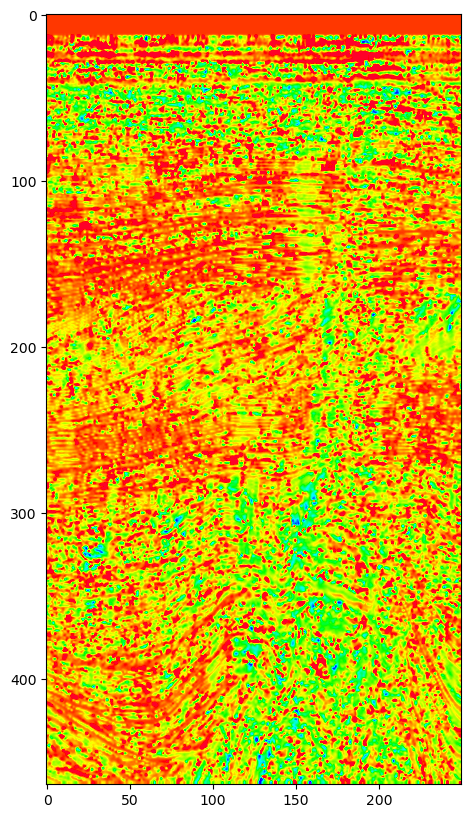

In [143]:
freq = inst_freq(data, dt=0.004)

plt.figure(figsize=(6, 10))
plt.imshow(freq[6].T, cmap='gist_rainbow', interpolation='bicubic', vmin=-10)

C:\Users\IDasgupta2\AppData\Local\Temp\ipykernel_6236\1935291499.py:10: RuntimeWarning: divide by zero encountered in divide
  term = numerator / denominator
C:\Users\IDasgupta2\AppData\Local\Temp\ipykernel_6236\1935291499.py:10: RuntimeWarning: invalid value encountered in divide
  term = numerator / denominator


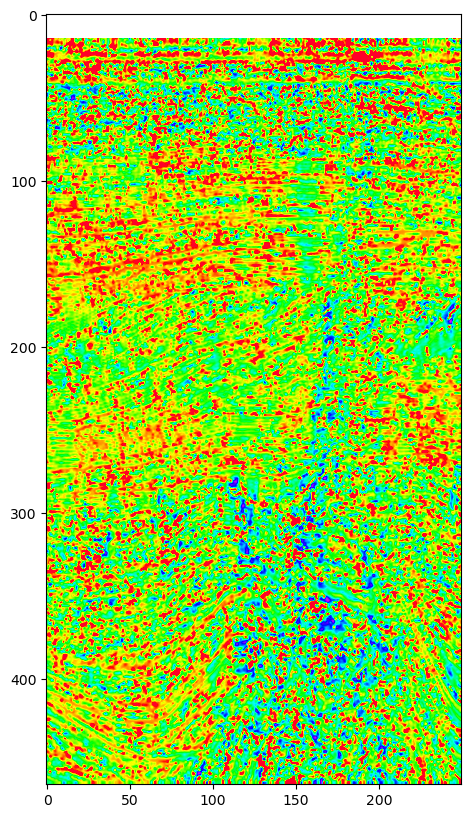

In [144]:
freq = inst_freq_scheuer_oldenburg(data, dt=0.004)

plt.figure(figsize=(6, 10))
plt.imshow(freq[6].T, cmap='gist_rainbow', interpolation='bicubic', vmin=-10)

C:\Users\IDasgupta2\AppData\Local\Temp\ipykernel_6236\2142938554.py:9: RuntimeWarning: invalid value encountered in divide
  term = numerator / denominator
C:\Users\IDasgupta2\AppData\Local\Temp\ipykernel_6236\1935291499.py:10: RuntimeWarning: divide by zero encountered in divide
  term = numerator / denominator
C:\Users\IDasgupta2\AppData\Local\Temp\ipykernel_6236\1935291499.py:10: RuntimeWarning: invalid value encountered in divide
  term = numerator / denominator


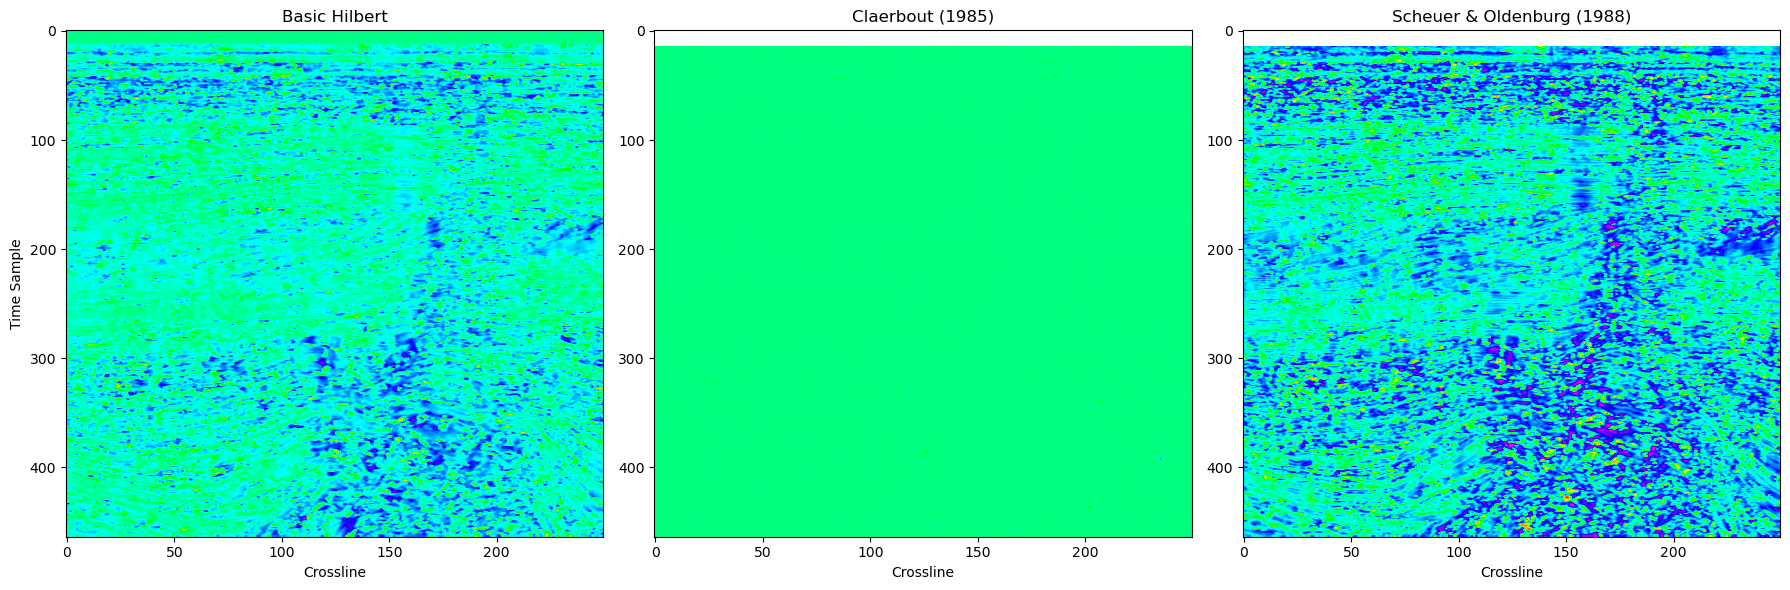

In [145]:
# Compute instantaneous frequency using all three methods
freq_basic = inst_freq(data, dt=0.004)
freq_claerbout = inst_freq_claerbout(data, dt=0.004)
freq_scheuer = inst_freq_scheuer_oldenburg(data, dt=0.004)

# Extract the 6th inline (index 5)
inline_index = 5
freq_basic_6th = freq_basic[inline_index]
freq_claerbout_6th = freq_claerbout[inline_index]
freq_scheuer_6th = freq_scheuer[inline_index]

# Plot side-by-side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Basic Hilbert")
plt.imshow(freq_basic_6th.T, cmap='gist_rainbow', aspect='auto', interpolation='bicubic')
plt.xlabel("Crossline")
plt.ylabel("Time Sample")

plt.subplot(1, 3, 2)
plt.title("Claerbout (1985)")
plt.imshow(freq_claerbout_6th.T, cmap='gist_rainbow', aspect='auto', interpolation='bicubic')
plt.xlabel("Crossline")

plt.subplot(1, 3, 3)
plt.title("Scheuer & Oldenburg (1988)")
plt.imshow(freq_scheuer_6th.T, cmap='gist_rainbow', aspect='auto', interpolation='bicubic')
plt.xlabel("Crossline")

plt.tight_layout()
plt.show()

# Semblance, coherence, and other discontinuity attributes

*Discontinuity attributes* are a variety of poststack calculations
that measure the degree of local similarity or dissimilarity between seismic traces. Discontinuities in a seismic volume, such
as faults or mass-transport deposits, are apparent as regions of
low similarity. Therefore, discontinuity attributes most often
are applied to highlight faults in a seismic volume but are also
useful in detecting subtle stratigraphic features in map view.
Semblance-based coherence (Marfurt et al., 1998), eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999), and
other discontinuity attributes are among the most widely applied
seismic attributes today.

The terminology used for discontinuity attributes can be
confusing. Terms such as coherence, semblance, similarity, discontinuity, and many others are used to refer to both the general class of attribute and to specific algorithms. 

In [146]:
# Prerequisites
from scipy.ndimage import generic_filter , gaussian_filter1d

### *Moving Window*

The earliest discontinuity algorithm was developed by Bahorich and Farmer (1995) and used the maximum crosscorrelation value of three traces. Each trace is correlated with a “moving-window” subset of two neighboring traces. Bahorich and Farmer (1995) coin the term coherence for the attribute, based on its conceptual similarity to prestack methods for estimating stacking velocities (e.g., Taner and Koehler,1969). Although this exact approach is computationally expensive and is not used widely today, it provides a starting point to understand later algorithms.

In [147]:
def moving_window(traces, func, window):
    """
    Helper function for multi-trace attribute generation.
    Applies a 3D function to a region of shape `window` over a dataset `traces`.
    
    :param traces: 3D NumPy array (inline, crossline, time/depth).
    :param func: Function to apply to each windowed region.
    :param window: Tuple of window sizes (inline, crossline, time/depth).
    :return: 3D array with the function applied to each window.
    """
    wrapped = lambda x: func(x.reshape(window))
    return generic_filter(traces, wrapped, window)

#The wrapped lambda reshapes the windowed data into the specified window shape before passing it to func. 
#The generic_filter function handles the sliding window operation efficiently.

### *Marfurt Coherence Method*

The approach of Bahorich and Farmer (1995) was successful, but it is sensitive to noise because only three traces are
used. Marfurt et al. (1998) generalize Bahorich and Farmer’s
crosscorrelation approach to an arbitrary number of input
traces, referred to by Marfurt et al. (1998)

The marfurt function implements the coherence calculation described by Marfurt et al. (1999). It measures the similarity between seismic traces within a window, which helps identify discontinuities (e.g., faults or stratigraphic changes).

***Marfurt, K., V. Sudhaker, A. Gersztenkorn, K. D. Crawford, and S. E. Nissen, 1999,
    Coherency calculations in the presence of structural dip: GEOPHYSICS, 64, 104-111.
    doi:10.1190/1.1444508***

In [148]:
def marfurt(traces):
    """
    Compute Marfurt coherence (Marfurt et al., 1999).
    
    :param traces: 3D NumPy array (inline, crossline, time/depth).
    :return: 1D array of coherence values along time/depth axis.
    """
    i, x, t = traces.shape
    traces = traces.reshape(-1,t) #Flatten inline and crossline
    square_sums = np.sum(traces, axis = 0)**2
    sum_squares = np.sum(traces**2, axis = 0)
    c = square_sums.sum()/(sum_squares.sum() + 1e-12)
    return c/(i*x)

#High coherence (close to 1) indicates similar traces (continuous geology), while low coherence indicates discontinuities (e.g., faults).

Conceptually, the algorithm of Marfurt et al. (1998) treats
each seismic trace within the moving window as a separate
dimension and measures how close the resulting point cloud is
to a hyperplane with a slope of 1 in all directions and an intercept of 0. It is easiest to visualize for the case of two traces, as
shown in Figure 2c. In that case, semblance-based coherence
computes how close the points fall to a line with a slope of 1
and an intercept of 0.

### *Gersztenkorn Coherence Method*

One caveat to the methods of Bahorich and Farmer (1995) and Marfurt
et al. (1998) is that they are sensitive
to lateral differences in amplitude and
in phase. Although this is desirable for
detecting stratigraphic features, *differences caused by amplitude can obscure subtle structural features*. Gersztenkorn and Marfurt (1999) propose
an implementation that is sensitive only
to *lateral changes in phase of the input
waveforms* — **eigenstructure-based coherence**.

Eigenstructure-based coherence
(Gersztenkorn and Marfurt, 1999)
computes the covariance matrix of the
input region. However, it uses the ratio of
the largest eigenvalue of the covariance
matrix to the sum of the eigenvalues.

In [149]:
def gersztenkorn(traces):
    traces = traces.reshape(-1, traces.shape[-1])
    cov = traces.dot(traces.T) # Compute covariance matrix
    vals = np.linalg.eigvalsh(cov) # Calculate eigenvalues
    return vals.max() / (vals.sum() + 1e-12)

#A high ratio indicates coherent traces; a low ratio suggests discontinuities.

## *Gradient Computation*

An entirely different approach than any we have discussed so
far is to apply a structure tensor to seismic attributes. The structure tensor measures how the gradient of each dimension covaries
locally. Randen et al. (2000) were the first to propose this approach
in their gradient-structure-tensor (GST) attributes. Several useful attributes can be computed from the ratios of the eigenvalues
of the structure tensor, one of which is a measure of how planar
the data are locally, which we will refer to as GST coherence

The gradients function computes the spatial and temporal gradients of the seismic data using a Gaussian filter. Gradients are used in the Gradient Structure Tensor (GST) method to analyze structural changes.

In [150]:
def gradients(traces, sigma):
    """
    Compute gradients along all axes of seismic data using Gaussian filtering.
    
    """
    grads = []
    # Compute gradient along each axis (inline, crossline, time)
    for axis in range(3):
        grad = gaussian_filter1d(traces, sigma, axis=axis, order=1)
        grads.append(grad[..., np.newaxis])
    # Concatenate gradients along new axis
    return np.concatenate(grads, axis=3)

### *Moving Window for 4D Gradient Data*

The moving_window4d function applies a function over a moving window on 4D gradient data, reducing it to a 3D output. It’s used specifically for the GST method to process gradient tensors.

In [151]:
def moving_window4d(grad, window, func):
    """
    Apply a function over a moving window on 4D gradient data.

    """
    # Pad spatial dimensions, leave gradient dimension unpadded
    half_window = [(x // 2, x // 2) for x in window] + [(0, 0)]
    padded = np.pad(grad, half_window, mode='reflect')
    
    # Initialize output array
    out = np.empty(grad.shape[:3], dtype=float)
    # Iterate over each voxel
    for i, j, k in np.ndindex(out.shape):
        region = padded[i:i+window[0], j:j+window[1], k:k+window[2], :]
        out[i, j, k] = func(region)
    return out

Notes:

1. Padding ensures boundary conditions are handled using reflection.
2. The function iterates explicitly over the 3D grid for clarity, though this could be optimized with vectorization.
3. The gradient dimension (last axis) is preserved during windowing.

### *Gradient Structure Tensor (GST) Calculation*

The gst_calc function computes the discontinuity metric from the gradient structure tensor by analyzing eigenvalues of the tensor formed from gradient vectors.


In [152]:
def gst_calc(region):
    region = region.reshape(-1, 3) # Reshape to 2D (spatial points, gradient components)
    gst = region.T.dot(region) # Compute gradient structure tensor
    eigs = np.sort(np.linalg.eigvalsh(gst))[::-1] # Sort eigenvalues in descending order
    # Compute discontinuity metric
    return (eigs[0] - eigs[1]) / (eigs[0] + eigs[1] + 1e-12)
    #The eigenvalue ratio (eigs[0] - eigs[1]) / (eigs[0] + eigs[1]) measures structural coherence.
    #A small value indicates coherence; a large value indicates discontinuities.

### *GST Discontinuity Method*

The gst_discontinuity function combines gradient computation and GST calculation to produce a discontinuity attribute using the Gradient Structure Tensor method.

In [153]:
def gst_discontinuity(seismic, window, sigma=1):
    # Compute gradients
    grad = gradients(seismic, sigma) #sigma controls gradient smoothness.
    # Apply GST calculation over moving window
    return moving_window4d(grad, window, gst_calc)

### *Putting it all together*

The **discontinuity function** compute discontinuity using one of three methods (Marfurt, Gersztenkorn, or GST). It handles both 2D and 3D seismic data and configures the window size based on input parameters.

In [154]:
def discontinuity(traces, duration, dt, step_out=1, kind='gst', sigma=1):

    # Handle 2D or 3D input
    if traces.ndim == 2:
        traces = traces[:, None, :]  # Add singleton xline dimension
        window = (2 * step_out + 1, 1, int(duration / dt))
    elif traces.ndim == 3:
        window = (2 * step_out + 1, 2 * step_out + 1, int(duration / dt))
    else:
        raise NotImplementedError("Expected 2D or 3D seismic data.")
    
    # Define available methods
    methods = {
        "marfurt": moving_window(traces, marfurt, window),
        "gersztenkorn": moving_window(traces, gersztenkorn, window),
        "gst": gst_discontinuity(traces, window, sigma)
    }
    
    # Return result, removing singleton dimensions
    return np.squeeze(methods[kind])

The output of the discontinuity function is a 2D or 3D array of discontinuity values, where higher values indicate potential geological discontinuities (e.g., faults). Each method has different sensitivities:

1. Marfurt: Fast, sensitive to trace similarity.
2. Gersztenkorn: Robust, uses eigenstructure for coherence.
3. GST: Detailed, accounts for structural orientation via gradients.
Example Interpretation:

For a 3D seismic volume (50, 50, 100), the output is a 3D array of the same spatial dimensions.
For a 2D section (100, 1000), the output is a 2D array (100, 1000).
Values close to 0 indicate coherent regions; higher values indicate discontinuities.

In [155]:
data.shape

(10, 250, 463)

In [156]:
#semblance
semb = discontinuity(data, duration = 0.036,dt = 0.004, kind = 'gst')

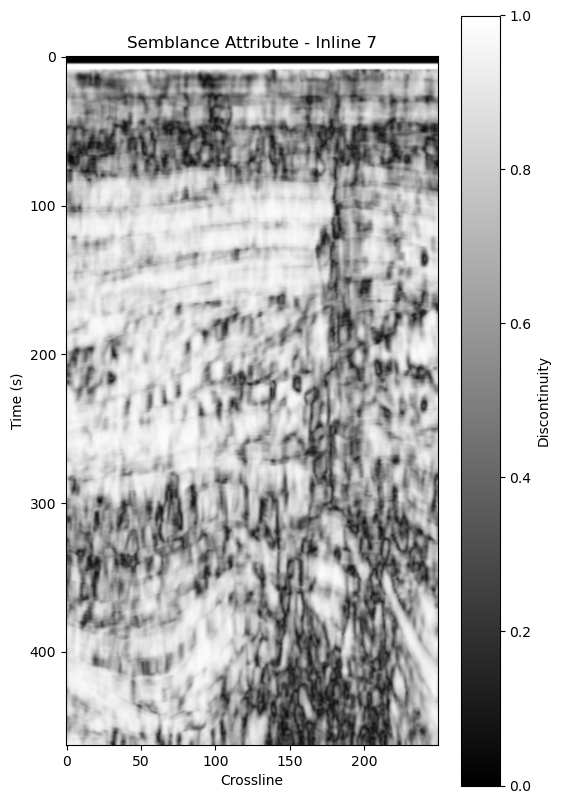

In [157]:
plt.figure(figsize = (6,10))
plt.imshow(semb[6].T , cmap = 'gray', interpolation = 'bicubic')
plt.title("Semblance Attribute - Inline 7")
plt.colorbar(label='Discontinuity')
plt.xlabel('Crossline')
plt.ylabel('Time (s)')
plt.show()

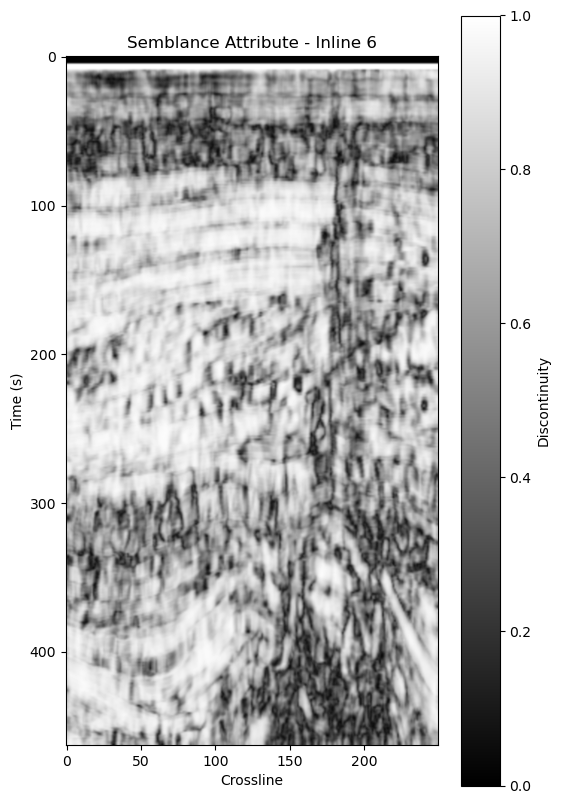

In [163]:
plt.figure(figsize = (6,10))
plt.imshow(semb[5].T , cmap = 'gray', interpolation = 'bicubic')
plt.title("Semblance Attribute - Inline 6")
plt.colorbar(label='Discontinuity')
plt.xlabel('Crossline')
plt.ylabel('Time (s)')
plt.show()

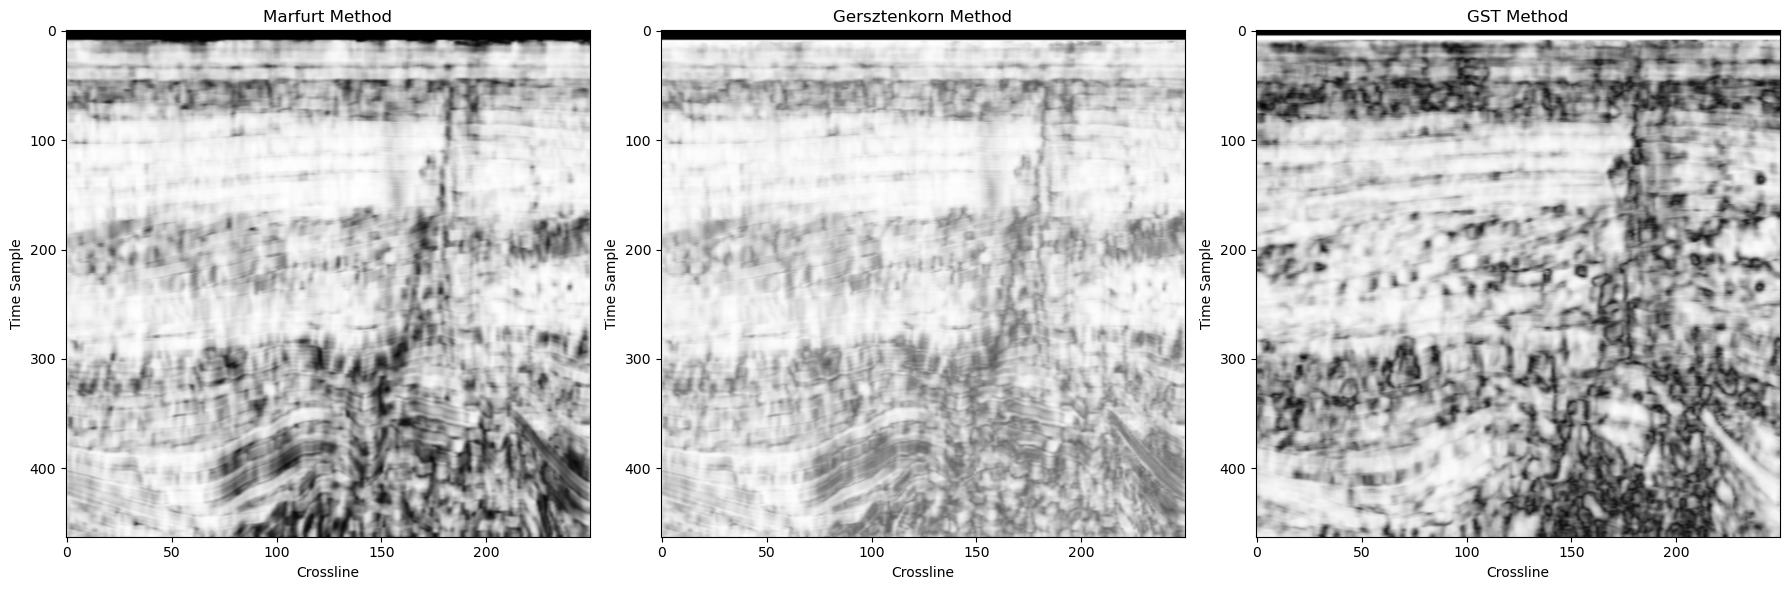

In [159]:
semb_marfurt = discontinuity(data, duration = 0.036,dt = 0.004, kind = 'marfurt')
semb_gersztenkorn = discontinuity(data, duration = 0.036,dt = 0.004, kind = 'gersztenkorn')
semb_gst = discontinuity(data, duration = 0.036,dt = 0.004, kind = 'gst')

# Plot side-by-side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Marfurt Method")
plt.imshow(semb_marfurt[6].T, cmap='gray', aspect='auto', interpolation='bicubic')
plt.xlabel("Crossline")
plt.ylabel("Time Sample")

plt.subplot(1, 3, 2)
plt.title("Gersztenkorn Method")
plt.imshow(semb_gersztenkorn[6].T, cmap='gray', aspect='auto', interpolation='bicubic')
plt.xlabel("Crossline")
plt.ylabel("Time Sample")

plt.subplot(1, 3, 3)
plt.title("GST Method")
plt.imshow(semb_gst[6].T, cmap='gray', aspect='auto', interpolation='bicubic')
plt.xlabel("Crossline")
plt.ylabel("Time Sample")

plt.tight_layout()
plt.show()

Because GST coherence measures change in the local slope of
the data, it is related more closely to curvature attributes than to the
other discontinuity attributes we have discussed (Randen et al., 2000;
Chopra and Marfurt, 2007). Therefore, GST coherence can reveal
different features than discontinuity attributes that compare waveform
similarity, but it tends to show thicker regions of discontinuity around
faults